#Description

**Project Statement:**

Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco port.

The company’s management has set out to build a bias-free/ corruption-free automatic system that reports & avoids faulty situations caused by human error. Examples of human error include misclassifying the correct type of boat. The type of boat that enters the port region is as follows.

*   Buoy
*   Cruise_ship
*   Ferry_boat
*   Freight_boar
*   Gondola
*   Inflatable_boat
*   Kayak
*   Paper_boat
*   Sailboat

Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that recognizes the boat. The company is also looking to use a transfer learning approach of any lightweight pre-trained model in order to deploy in mobile devices.

As a deep learning engineer, your task is to:

1.   Build a CNN network to classify the boat.
2.   Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

**Dataset and Data Description:**

The dataset contains images of 9 types of boats. It contains a total of 1162 images. The training images are provided in the directory of the specific class itself.

**Classes:**


*   ferry_boat
*   gondola
*   sailboat
*   cruise_ship
*   kayak
*   inflatable_boat
*   paper_boat
*   buoy
*   freight_boat

**Perform the following steps:**

---



# Import necessary libraries

In [34]:
# Import required libraries
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
# Note that Keras should only be imported after the backend
# has been configured. The backend cannot be changed once the
# package is imported.
import keras

# Core Libraries for Data Handling and Analysis:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import shutil
from keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from keras.applications import MobileNetV2
from keras.layers import Dropout, BatchNormalization

# 1.	Build a CNN network to classify the boat.

This code implements a Convolutional Neural Network (CNN) for image classification using TensorFlow and Keras.

In [35]:
# Loading data
import pathlib
image_dir  = pathlib.Path('/content/boat_type_classification_dataset') # Convert the string to a Path object

# Check directroy exits or not
if not image_dir.exists():
    print(f"The directory {image_dir} does not exist")
else:
    print(f"The directory {image_dir} exists")

image_files = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], image_files))

image_df = pd.DataFrame({'Filepath': image_files, 'Label': labels}).astype(str).sample(frac=1.0, random_state=1).reset_index(drop=True)
image_df.head(4)

The directory /content/boat_type_classification_dataset exists


,Filepath,Label
0,/content/boat_type_classification_dataset/crui...,cruise_ship
1,/content/boat_type_classification_dataset/gond...,gondola
2,/content/boat_type_classification_dataset/ferr...,ferry_boat
3,/content/boat_type_classification_dataset/gond...,gondola


In [36]:
image_df['Label'].value_counts()

,count
Label,
sailboat,389
kayak,203
gondola,193
cruise_ship,191
ferry_boat,63
paper_boat,31
freight_boat,23
inflatable_boat,16


1.1.	Split the dataset into train and test in the ratio 80:20, with shuffle and random state=43.

In [37]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=43, stratify=image_df['Label'])
display(train_df.head())
display(test_df.head())

,Filepath,Label
165,/content/boat_type_classification_dataset/gond...,gondola
185,/content/boat_type_classification_dataset/kaya...,kayak
578,/content/boat_type_classification_dataset/crui...,cruise_ship
831,/content/boat_type_classification_dataset/crui...,cruise_ship
633,/content/boat_type_classification_dataset/infl...,inflatable_boat


,Filepath,Label
217,/content/boat_type_classification_dataset/sail...,sailboat
393,/content/boat_type_classification_dataset/infl...,inflatable_boat
1017,/content/boat_type_classification_dataset/sail...,sailboat
696,/content/boat_type_classification_dataset/sail...,sailboat
287,/content/boat_type_classification_dataset/ferr...,ferry_boat


### Data preprocessing

1.2.	Use Keras ImageDataGenerator to initialize the train generator with validation_split=0.2 and test generator. Generators are required to avoid out of memory issues while training

In [38]:
# Initialize ImageDataGenerator for training data with normalization (rescale=1./255) and validation split
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Initialize ImageDataGenerator for testing data with normalization (rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

1.4.	Load train, validation and test dataset in batches of 32 using the generators initialized in the above step.

In [39]:
# Create training data generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Create testing data generator
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label', # Changed 'label' to 'Label'
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Print confirmation messages
print("Training data generator created.")
print("Validation data generator created.")
print("Testing data generator created.")

Found 710 validated image filenames belonging to 8 classes.
Found 177 validated image filenames belonging to 8 classes.
Found 222 validated image filenames belonging to 8 classes.
Training data generator created.
Validation data generator created.
Testing data generator created.


We build a CNN network using Keras, then compile it using Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall.

### Build CNN model

1.5.	Build a CNN network using Keras with the following layers

  •	Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D

  •	Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D

  •	GLobalAveragePooling2D layer

  •	Dense layer with 128 neurons and activation relu

  •	Dense layer with 128 neurons and activation relu

  •	Dense layer with 9 neurons and activation softmax.


In [40]:
#  CNN model using Keras Sequential API with the specified layers and print the model summary.
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    # Dense(9, activation='softmax')
    # Dense(train_generator.num_classes, activation='softmax')
    Dense(len(train_generator.class_indices), activation='softmax')
])
model.name = "CNN_Model"

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,160 (160.78 KB)

 Trainable params: 41,160 (160.78 KB)

 Non-trainable params: 0 (0.00 B)

### Display the input and output shapes of each layer in the plotted graph:

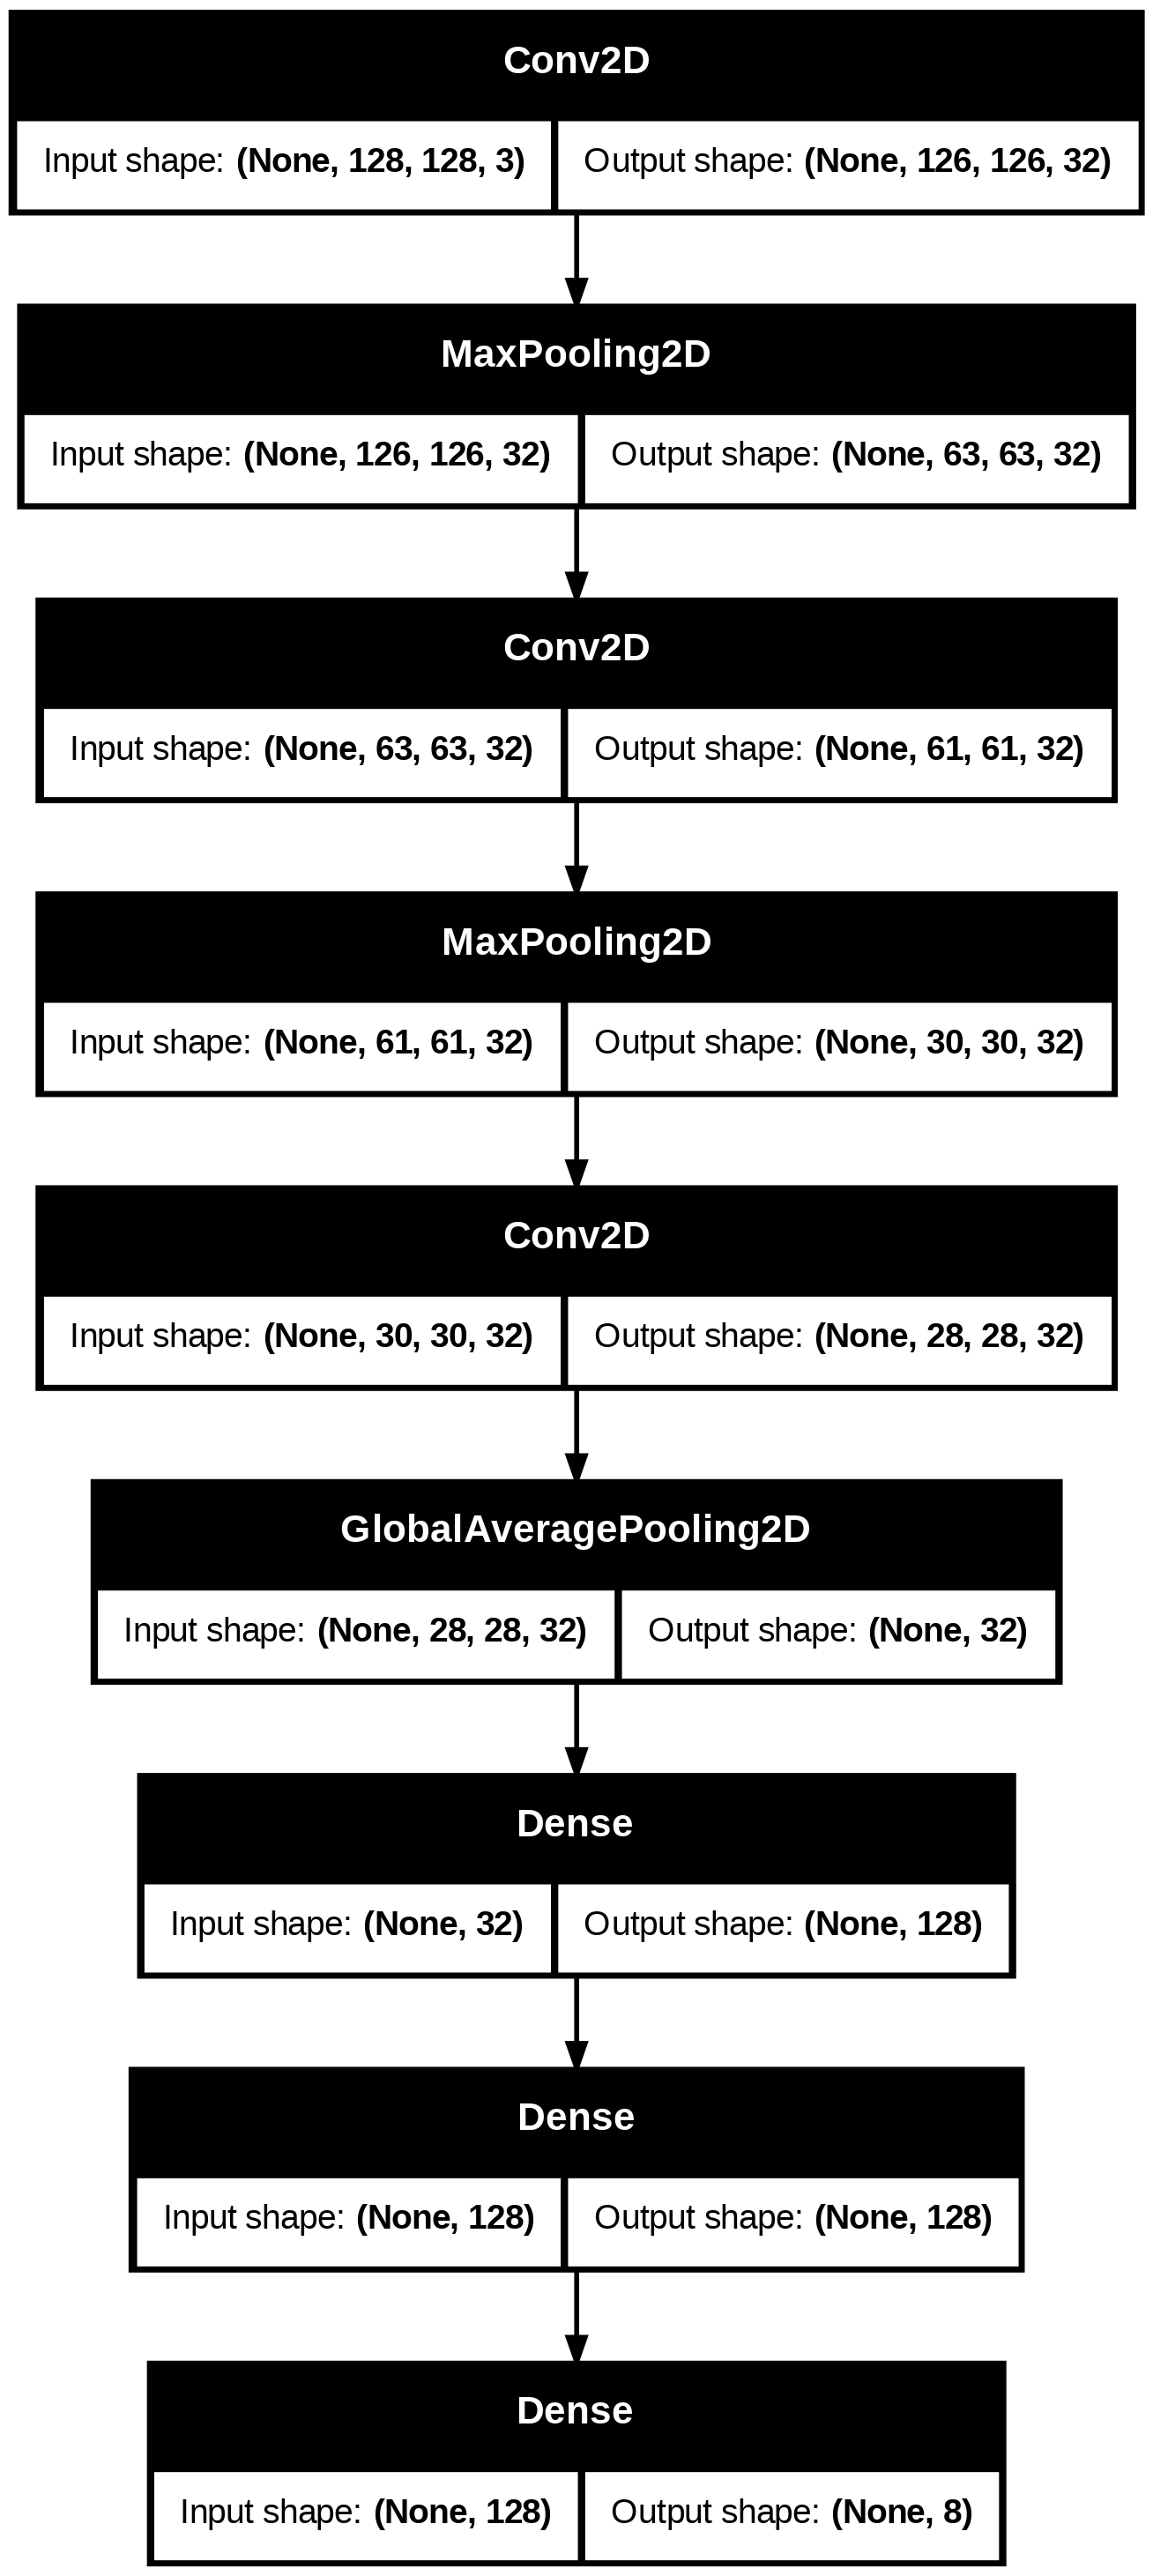

In [41]:
tf.keras.utils.plot_model(model, "CNN_Model_shape_info.png", show_shapes=True)

### Model compilation
1.6.	Compile the model with Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall


In [42]:
# Compile the model with Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall
learning_rate=1e-3
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

### Model training
1.7.	Train the model for 20 epochs and plot training loss and accuracy against epochs.

In [43]:
# Define EarlyStopping callback
batch_size = 128
epochs = 20

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
    # tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,restore_best_weights=True),
]
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# we have imbalanced image set per class, we use weight such that class with lower number of sampels gets higher weights.
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // train_generator.batch_size,
    # validation_steps=validation_generator.samples // validation_generator.batch_size,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    # callbacks=[early_stopping],
    # callbacks=callbacks,
    class_weight=class_weights_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 886ms/step - accuracy: 0.1350 - loss: 2.0666 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.2147 - val_loss: 2.0619 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 971ms/step - accuracy: 0.1754 - loss: 2.0852 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.1977 - val_loss: 2.0622 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 889ms/step - accuracy: 0.1576 - loss: 2.0507 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.1582 - val_loss: 2.0278 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 888ms/step - accuracy: 0.2187 - loss: 2.1244 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.2147 - val_loss: 2.0320 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 816ms/step - accur

### Model Evaluate
1.8.	Evaluate the model on test images and print the test loss and accuracy.

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.2652 - loss: 1.8293 - precision_2: 0.1169 - recall_2: 0.0107
Test Loss: 1.844846487045288
Test Accuracy: 0.2612612545490265


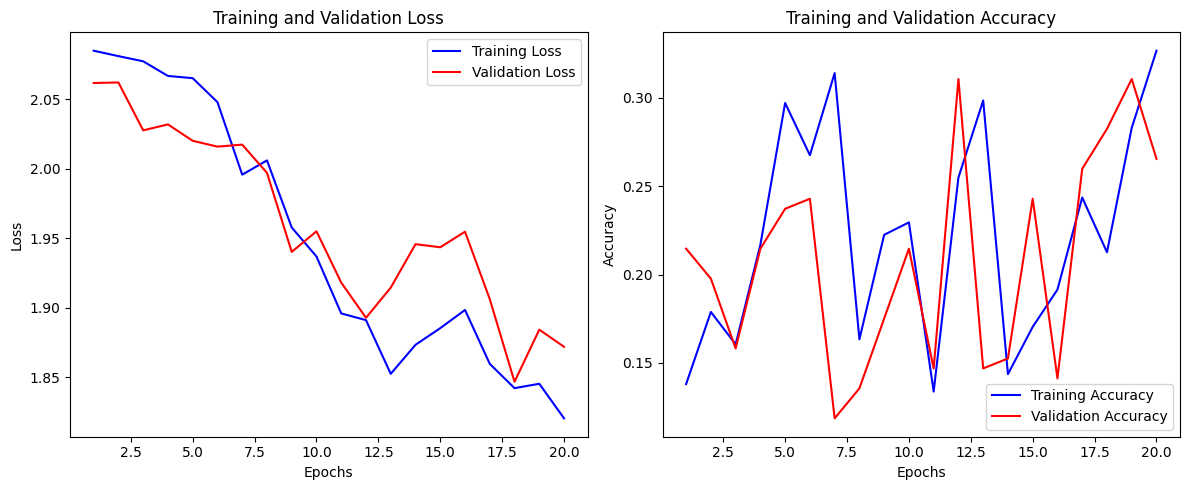

In [44]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Extract training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 1.9.	Plot heatmap of the confusion matrix and print classification report

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.2652 - loss: 1.8293 - precision_2: 0.1169 - recall_2: 0.0107
Test Loss: 1.844846487045288
Test Accuracy: 0.2612612545490265
Test Precision: 0.07692307978868484
Test Recall: 0.0045045046135783195
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step


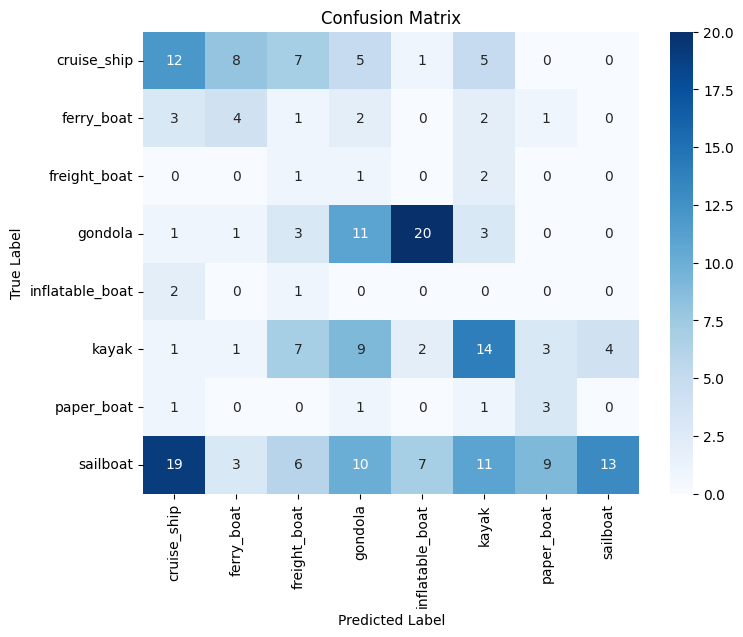

Classification Report
                 precision    recall  f1-score   support

    cruise_ship       0.31      0.32      0.31        38
     ferry_boat       0.24      0.31      0.27        13
   freight_boat       0.04      0.25      0.07         4
        gondola       0.28      0.28      0.28        39
inflatable_boat       0.00      0.00      0.00         3
          kayak       0.37      0.34      0.35        41
     paper_boat       0.19      0.50      0.27         6
       sailboat       0.76      0.17      0.27        78

       accuracy                           0.26       222
      macro avg       0.27      0.27      0.23       222
   weighted avg       0.46      0.26      0.29       222



In [45]:
# Plot heatmap of the confusion matrix and print classification report
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

# Get the true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=target_names))


# Main Task 2

2.	Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

### 2.1.	Split the dataset into train and test datasets in the ration 70:30, with shuffle and random state=1.

In [46]:
#split it between train and test sets 70: 30 ration
train_df, test_df = train_test_split(image_df, test_size=0.3, shuffle=True, random_state=1, stratify=image_df['Label'])

### 2.2.	Use Keras ImageDataGenerator to initialize the train generator with validation_split=0.2 and test generator. Generators are required to avoid out-of-memory issues while training.

2.3.	Both generators will be initialized with data normalization.
(Hint: rescale=1./255).


In [47]:
# initializ ImageDataGenerator for train and test with data normalization
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

### 2.4.	Load train, validation and test datasets in batches of 32 using the generators initialized in the above step.

In [48]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 621 validated image filenames belonging to 8 classes.
Found 155 validated image filenames belonging to 8 classes.
Found 333 validated image filenames belonging to 8 classes.


### 2.5.	Build a CNN network using Keras with the following layers

•	Load MobileNetV2 - Light Model as the first layer
(Hint: Keras API Doc)

•	GLobalAveragePooling2D layer

•	Dropout(0.2)

•	Dense layer with 256 neurons and activation relu

•	BatchNormalization layer

•	Dropout(0.1)

•	Dense layer with 128 neurons and activation relu

•	BatchNormalization layer

•	Dropout(0.1)

•	Dense layer with 9 neurons and activation softmax


In [49]:
# Load MobileNetV2 with pre-trained weights from ImageNet, excluding the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Set base model layers to be non-trainable (freezing them)
base_model.trainable = False
# for layer in base_model.layers:
#     layer.trainable = False

# Build the CNN model using Keras Sequential API
tf_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(len(train_gen.class_indices), activation='softmax')
])
tf_model.name = "Transfer_Learning_Model"

# Print the model summary
tf_model.summary()

Model: "Transfer_Learning_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,384 (10.00 MB)

 Trainable params: 362,632 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

### Display the input and output shapes of each layer in the plotted graph:

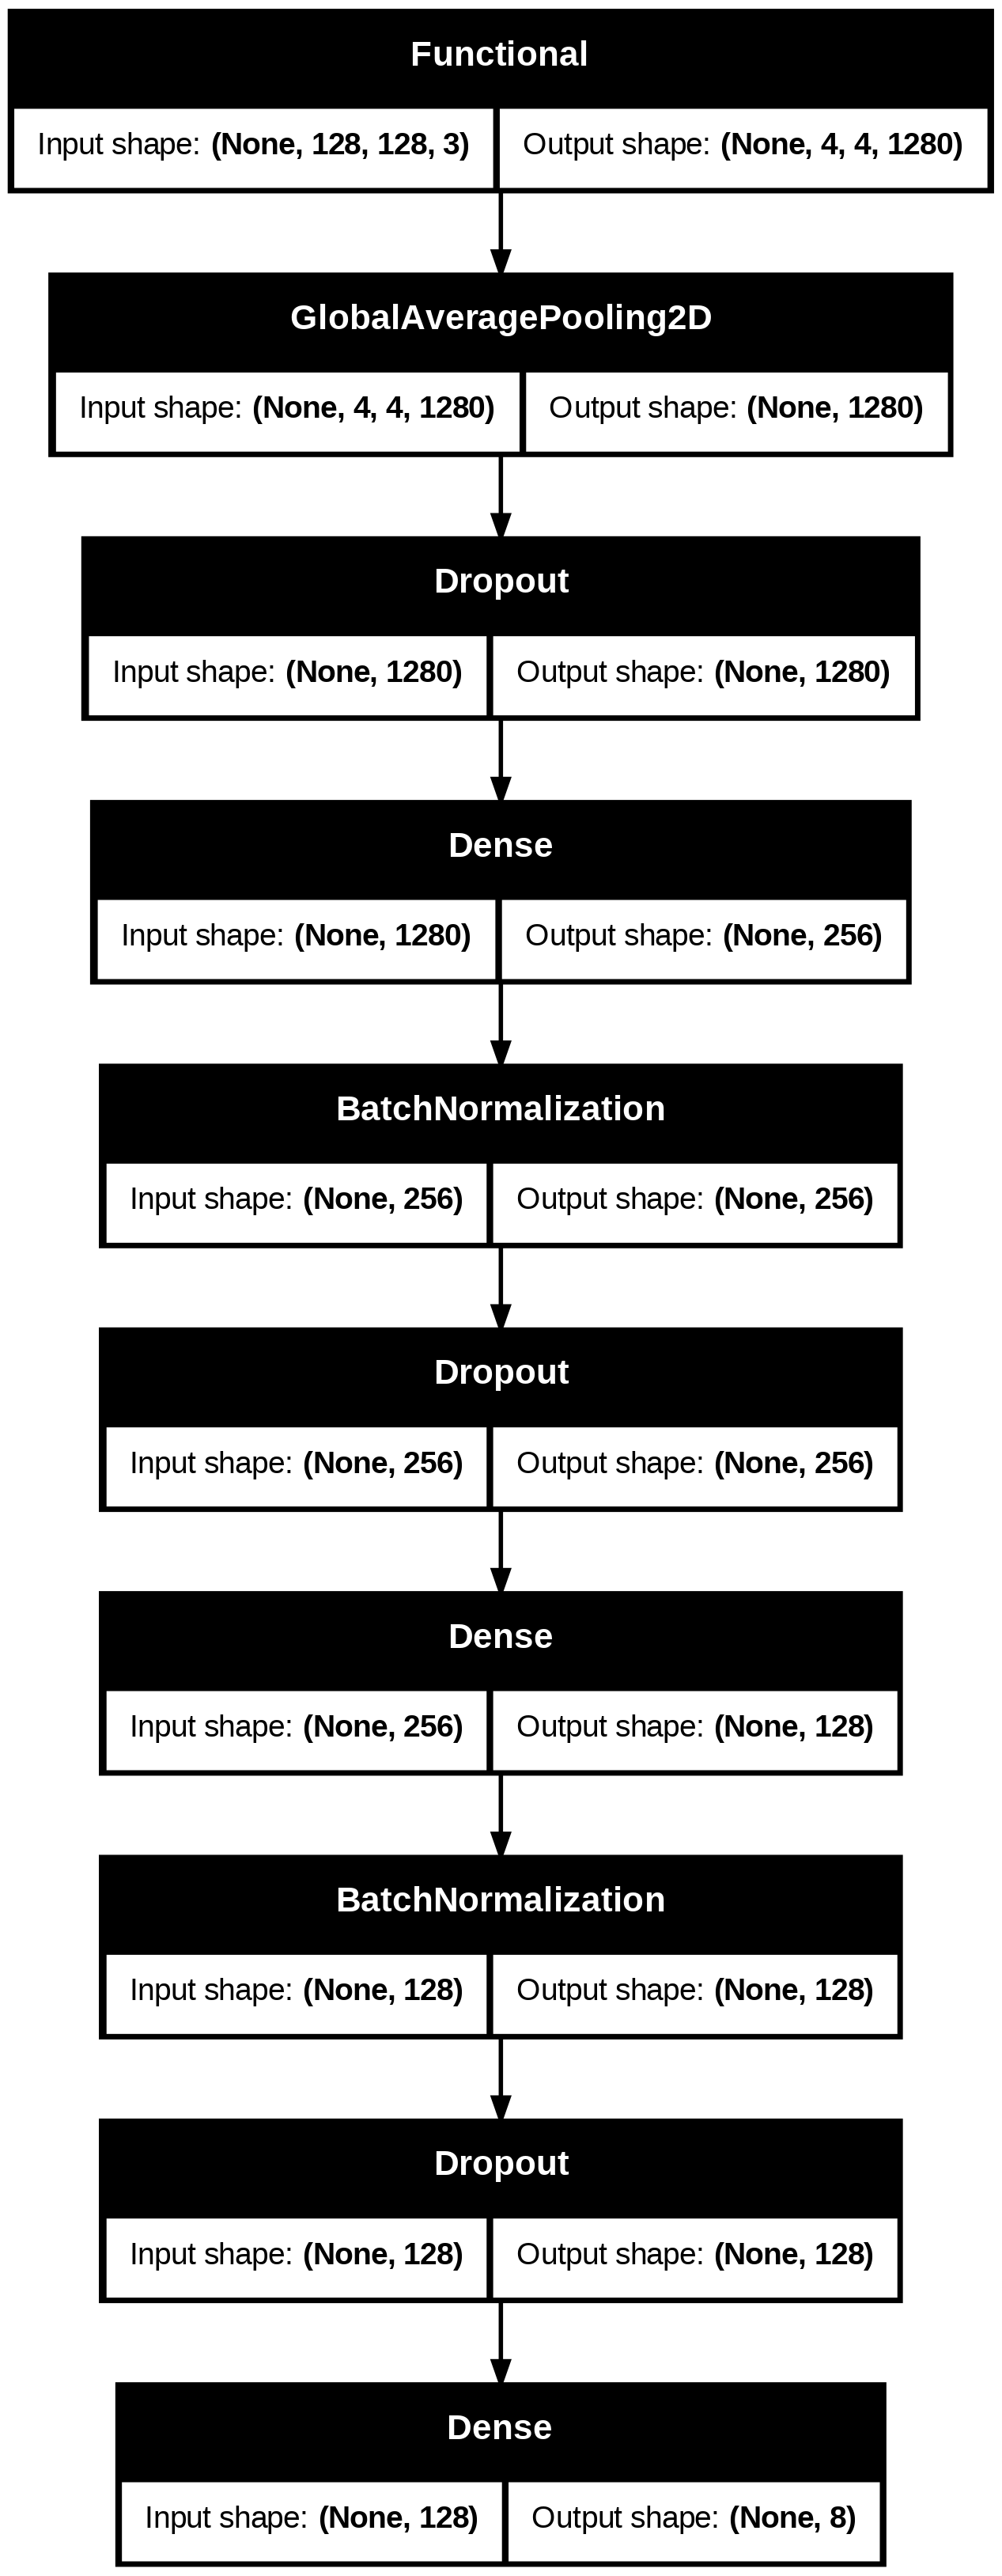

In [50]:
tf.keras.utils.plot_model(tf_model, "Transfer_Learning_Model.png", show_shapes=True)

### 2.6.	Compile the model with Adam optimizer, categorical_crossentropy loss, and metrics accuracy, Precision, and Recall.

In [51]:
# Compile the model with Adam optimizer, categorical_crossentropy loss, and metrics accuracy, Precision, and Recall.

tf_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


### 2.7.	Train the model for 50 epochs and Early stopping while monitoring validation loss.

In [52]:
epochs = 50
batch_size = 128

# Define EarlyStopping callback with monitor val loss
callbacks = [
    # tf.keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,restore_best_weights=True),
]

# Train the model
tf_history = tf_model.fit(
    train_gen,
    # steps_per_epoch=train_gen.samples // train_gen.batch_size,
    # validation_steps=validation_gen.samples // validation_gen.batch_size,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_gen,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 844ms/step - accuracy: 0.3684 - loss: 1.9815 - precision_3: 0.4999 - recall_3: 0.2489 - val_accuracy: 0.6645 - val_loss: 0.9441 - val_precision_3: 0.7453 - val_recall_3: 0.5097
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 702ms/step - accuracy: 0.7594 - loss: 0.5557 - precision_3: 0.8491 - recall_3: 0.6546 - val_accuracy: 0.7484 - val_loss: 0.7925 - val_precision_3: 0.8403 - val_recall_3: 0.6452
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 700ms/step - accuracy: 0.8641 - loss: 0.2845 - precision_3: 0.9322 - recall_3: 0.7989 - val_accuracy: 0.7742 - val_loss: 0.6945 - val_precision_3: 0.8271 - val_recall_3: 0.7097
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 696ms/step - accuracy: 0.9235 - loss: 0.2117 - precision_3: 0.9606 - recall_3: 0.8708 - val_accuracy: 0.8065 - val_loss: 0.6660 - val_precision_3: 0.8519 - val_recall_3: 0.7419
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 829ms/step - accuracy: 0.9475 - loss: 0.1390 - precision_3: 0.9777 - recall_3: 0.9

### 2.8.	Evaluate the model on test images and print the test loss and accuracy.

In [53]:
##valuate model
test_loss_tl, test_accuracy_tl, test_precision_tl, test_recall_tl = tf_model.evaluate(test_gen, verbose=1)

print(f'Test Loss: {test_loss_tl}')
print(f'Test Accuracy: {test_accuracy_tl}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 530ms/step - accuracy: 0.7855 - loss: 0.5494 - precision_3: 0.8869 - recall_3: 0.7525
Test Loss: 0.5862632989883423
Test Accuracy: 0.7747747898101807


### 2.9.	Plot Train loss Vs Validation loss and Train accuracy Vs Validation accuracy.

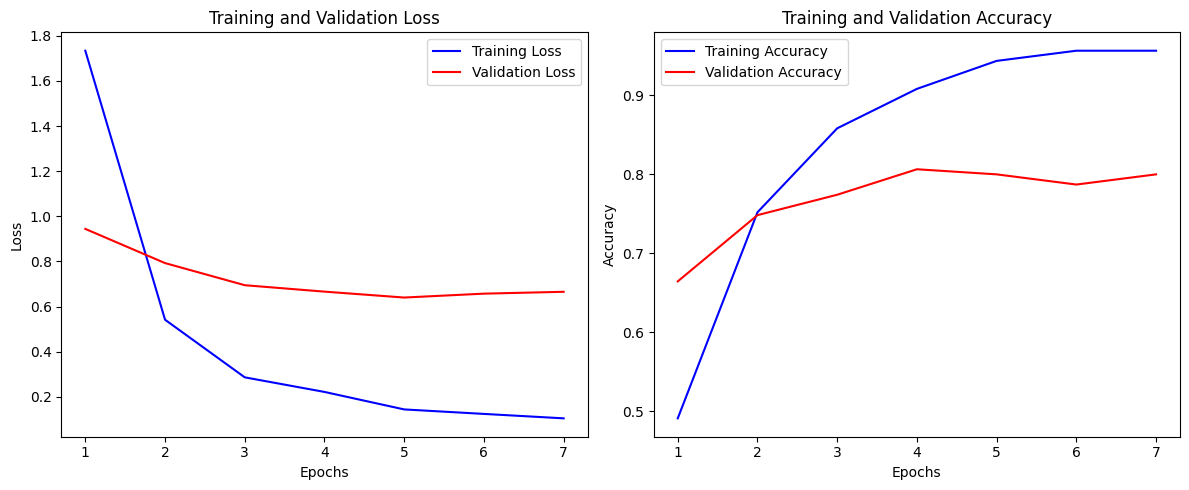

In [54]:
# Extract training and validation loss and accuracy
train_loss = tf_history.history['loss']
val_loss = tf_history.history['val_loss']
train_accuracy = tf_history.history['accuracy']
val_accuracy = tf_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 2.10. Plot heatmap of the confusion matrix and print classification report for the transfer learning model.

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 469ms/step - accuracy: 0.7855 - loss: 0.5494 - precision_3: 0.8869 - recall_3: 0.7525
Test Loss (Transfer Learning Model): 0.5862632989883423
Test Accuracy (Transfer Learning Model): 0.7747747898101807
Test Precision (Transfer Learning Model): 0.8645833134651184
Test Recall (Transfer Learning Model): 0.7477477192878723
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step


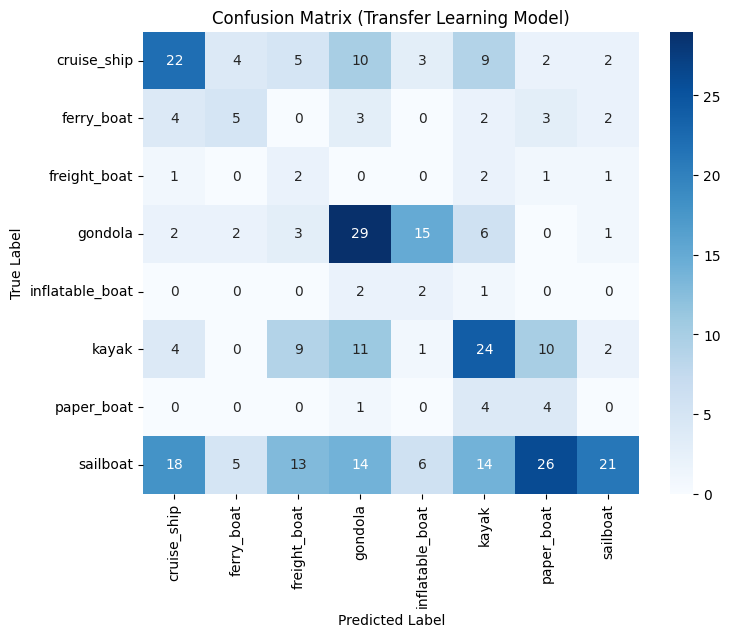

Classification Report (Transfer Learning Model)
                 precision    recall  f1-score   support

    cruise_ship       0.43      0.39      0.41        57
     ferry_boat       0.31      0.26      0.29        19
   freight_boat       0.06      0.29      0.10         7
        gondola       0.41      0.50      0.45        58
inflatable_boat       0.07      0.40      0.12         5
          kayak       0.39      0.39      0.39        61
     paper_boat       0.09      0.44      0.15         9
       sailboat       0.72      0.18      0.29       117

       accuracy                           0.33       333
      macro avg       0.31      0.36      0.27       333
   weighted avg       0.49      0.33      0.35       333



In [55]:
# Evaluate the transfer learning model on the test set
test_loss_tl, test_accuracy_tl, test_precision_tl, test_recall_tl = tf_model.evaluate(test_gen, verbose=1)

print(f'Test Loss (Transfer Learning Model): {test_loss_tl}')
print(f'Test Accuracy (Transfer Learning Model): {test_accuracy_tl}')
print(f'Test Precision (Transfer Learning Model): {test_precision_tl}')
print(f'Test Recall (Transfer Learning Model): {test_recall_tl}')

# Get the true labels and predictions for the transfer learning model
test_gen.reset()
Y_pred_tl = model.predict(test_gen)
y_pred_classes_tl = np.argmax(Y_pred_tl, axis=1)
y_true_tl = test_gen.classes

# Confusion Matrix for Transfer Learning Model
cm_tl = confusion_matrix(y_true_tl, y_pred_classes_tl)
plt.figure(figsize=(8,6))
sns.heatmap(cm_tl, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix (Transfer Learning Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report for Transfer Learning Model
print('Classification Report (Transfer Learning Model)')
target_names_tl = list(test_gen.class_indices.keys())
print(classification_report(y_true_tl, y_pred_classes_tl, target_names=target_names_tl))

### 3. Compare the results of both models built in steps 1 and 2 and state your observations.

**Summary:**

In [56]:
model_comparison  = pd.DataFrame({
    'Model': ['CNN Model', 'Transfer Learning Model'],
    'Test Loss': [test_loss, test_loss_tl],
    'Test Accuracy': [test_accuracy, test_accuracy_tl],
    'Test Precision': [test_precision, test_precision_tl],
    'Test Recall': [test_recall, test_recall_tl],
    'Total Parameters': [model.count_params(), tf_model.count_params()], # Added comma
    'Optimizer': [
        'Adam',
        'Adam'
    ],
    'Loss Function': [
        'categorical_crossentropy',
        'categorical_crossentropy'
    ], # Added comma
    'Early Stopping': [
        'No',
        'Yes'
    ],
    'Base Model': [
        'None',
        'MobileNetV2'
    ],
    'Batches': [
        32,
        32
    ],
    'Epochs': [
        20,
        50
    ]
})

# Comparison of Model Performance
display(model_comparison)

,Model,Test Loss,Test Accuracy,Test Precision,Test Recall,Total Parameters,Optimizer,Loss Function,Early Stopping,Base Model,Batches,Epochs
0,CNN Model,1.844846,0.261261,0.076923,0.004505,41160,Adam,categorical_crossentropy,No,None,32,20
1,Transfer Learning Model,0.586263,0.774775,0.864583,0.747748,2621384,Adam,categorical_crossentropy,Yes,MobileNetV2,32,50


## Observations:

Based on the model comparison, here are some observations

**Model Performance:**


*   The Transfer learning model achieved a higher test accuracy (0.77) compared to the CNN Model (0.26)
*   The test loss for the CNN Model (0.58) was much lower than the Transfer learning model (1.84)

*   The Transfer Learning Model also showed better precision (0.86) and recall (0.75) compared to the CNN Model P-0.076 and Rec-0.0045.
*   The Transfer Learning Model with MobileNetV2 as the base model significantly outperforms the custom CNN Model on this boat classification task. This highlights the power of transfer learning, especially on smaller datasets where training a deep CNN from scratch can be challenging.

**Observations from Confusion Matrices:**



*   the CNN Model performed very poorly, essentially classifying most images into a few dominant classes and having zero precision and recall for many classes
*   The Transfer Learning Model shows much better performance across most classes, although there are still some confusions between similar boat types





